In [1]:
from typing import Optional, Tuple
import os
import numpy as np
import torch
from tianshou.env import DummyVectorEnv

import torch

from pettingzoo.sisl import pursuit_v4
from TaskAllocation.RL_Policies.MultiHead_SISL import MultiHead_SISL

import os
import datetime
from typing import Optional, Tuple

import numpy as np
import torch
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager, RandomPolicy, RainbowPolicy
from TaskAllocation.RL_Policies.CNN_SISL import CNN_SISL
from TaskAllocation.RL_Policies.SISL_Task_MultiHead import SISL_Task_MultiHead

from pettingzoo.sisl import pursuit_v4
import Mods.TaskPursuitEnv as TaskPursuitEnv

from TaskAllocation.RL_Policies.MultiHead_SISL import MultiHead_SISL
from TaskAllocation.RL_Policies.DNN_SISL import DNN_SISL

from TaskAllocation.RL_Policies.Custom_Classes import CustomCollector

#from tianshou_DQN import train
model = "SISL_Task_MultiHead" #"MultiHead_SISL" 
policyModel = "DQN"

size = [16,16]
n_agents = 8
n_targes = 30
max_cycles = 500
obs_range = 9
render = False

episodes = 50

seed = 1

# Create a new instance of the policy with the same architecture as the saved policy
# name = 'policy_CNN_SISL_01_Hot46231121-161700_2497_' 
#name = 'policy_CNN_SISL_SISL_NOV12_Emb128231120-134122_5079' #final CNN OBS 7

#name = 'policy_CNN_SISL_Desk_CNN_FV5240130-181138_4424_BestRew' #final CNN OBS 5

#name = 'policy_CNN_SISL_Desk_CNN_FV5240129-120950_4202_BestRew' #nest OBS 5

name = 'policy_SISL_Task_MultiHead_Desk_NewExpFix_noActHist240121-212613_2461_BestRew' #Best Task-Based
#name =  'policy_CNN_SISL_Desk_CNN02240128-083000_3571_BestRew'
#name = 'policy_CNN_SISL_SISL_NOV12_Emb128231120-134122_242' # 1h15 
# name = 'policy_CNN_SISL_SISL_NOV12_ASAFull'


Policy_Config = {
    "same_policy" : True,
    "load_model" : True,
    "freeze_CNN" : False    
                }

dqn_params = {"discount_factor": 0.95, 
              "estimation_step": 2, 
              "target_update_freq": 800 * 4,
              "optminizer": "Adam",
              "lr": 1e-3 }

trainer_params = {"max_epoch": 500,
                  "step_per_epoch": 10 * (100 * 10 * 4),
                  "step_per_collect": 20 * (10 * 4),
                  "episode_per_test": 10,
                  "batch_size" : 4 * 32,
                  "update_per_step": 1 / 20, #Only run after close a Collect (run many times as necessary to meet the value)
                  "tn_eps_max": 0.95,
                  "ts_eps_max": 0.0,
                  }

def _get_env_eval():
    """This function is needed to provide callables for DummyVectorEnv."""   
    #env_paralell = MultiUAVEnv()  
    #env = pursuit_v4.env(
    env = TaskPursuitEnv.env(
        max_cycles=500,#max_cycles, 
        x_size=size[0], 
        y_size=size[1], 
        shared_reward=False, 
        n_evaders=n_targes,
        n_pursuers=n_agents,
        obs_range=obs_range, 
        n_catch=2, 
        freeze_evaders=False, 
        tag_reward=0.01,
        catch_reward=5.0, 
        urgency_reward=-0.1, 
        surround=True, 
        constraint_window=1.0,
        render_mode = "human" if render else None)
    #env = parallel_to_aec_wrapper(env_paralell)    
    #env = CustomParallelToAECWrapper(env_paralell)
    
    return PettingZooEnv(env)

def _get_agents(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    policy_load_path = None,
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    
    env = _get_env_eval()     
    env.seed(seed)  
    agent_observation_space = env.observation_space
   
    action_shape = env.action_space
    
    device="cuda" if torch.cuda.is_available() else "cpu"  

    agents = []        
    
    if Policy_Config["same_policy"]:
        policies_number = 1
    else:
        policies_number = len(env.agents)

    for _ in range(policies_number):      
               
        
        
        if model == "SISL_Task_MultiHead":
            net = SISL_Task_MultiHead(                
                num_tasks=20,
                num_features_per_task = 9,                
                device="cuda" if torch.cuda.is_available() else "cpu"
                
            ).to(device)

        
        if model == "CNN_SISL":
            net = CNN_SISL(
                obs_shape=agent_observation_space.shape,                
                action_shape=5,                
                device="cuda" if torch.cuda.is_available() else "cpu"
                
            ).to(device)            
              
        if Policy_Config["freeze_CNN"]:                
                net.freeze_conv_layers()  # Freeze the convolutional layers

                optim = torch.optim.Adam(
                    list(net.policy_fn.parameters()) + list(net.value_fn.parameters()), 
                    lr=dqn_params["lr"]
                )
        else:
            optim = torch.optim.Adam(net.parameters(), lr=dqn_params["lr"], weight_decay=0.0, amsgrad= True )                



        if policyModel == "DQN":
            agent_learn = DQNPolicy(
                model=net,
                optim=optim,
                action_space = action_shape,
                discount_factor= dqn_params["discount_factor"],
                estimation_step=dqn_params["estimation_step"],
                target_update_freq=dqn_params["target_update_freq"],
                reward_normalization = False,
                clip_loss_grad = False 
            ) 
         
        
        agents.append(agent_learn)

    if Policy_Config["same_policy"]:
        agents = [agents[0] for _ in range(len(env.agents))]    

    policy = MultiAgentPolicyManager(policies = agents, env=env)  
        
    return policy, optim, env.agents


policy, optim, agents = _get_agents()
     

# Load the saved checkpoint
for agent in agents:    
    
    if Policy_Config["same_policy"]:
        model_path = os.path.join("dqn_SISL", name + ".pth")                            
    else:
        model_path = os.path.join("dqn_SISL", name + agent + ".pth") 

    policy.policies[agent].set_eps(0.00)
    policy.policies[agent].load_state_dict(torch.load(model_path))
    policy.policies[agent].eval()
    

envs = DummyVectorEnv([_get_env_eval for _ in range(1)])


collector = CustomCollector(policy, envs, exploration_noise=False)

results = collector.collect(n_episode=episodes, render=0.02 if render else None)#0.02)#, gym_reset_kwargs={'seed' :2})

print("FinalRew: ", np.sum(results['rews'], axis = 1))
print("Finished: ", results['lens'] , " Steps")

print("Mean: ", results['rew'])
print("Std:  " , np.std (results['rews']))
print("Max:  " , np.max(results['rews']))
print("Min:  " , np.min(results['rews']))
# print("Mean Len: " , np.mean(results['lens']))

print(results['rews'])

FinalRew:  [696.36    627.15    560.83375 493.33    323.0275  453.      590.9375
 775.71625 700.7025  696.6425  742.70625 617.51375 581.92875 810.44625
 677.62    711.51625 545.32625 570.0325  528.01    711.92    414.96125
 630.97125 695.69875 755.50875 376.42375 452.01    503.3175  785.15125
 783.5     658.45625 481.20375 486.6325  533.50125 517.135   576.26625
 736.18    732.6     538.38375 786.09875 445.83375 680.52625 537.65125
 449.91375 536.89875 648.115   670.175   709.6825  829.3425  344.1025
 552.3375 ]
Finished:  [1296 1824 2112 1136 4000 1696 1800 1792 1632 1320 1448 1968 1208 1416
 1672 2192 1576 1232 1512 1712 2152 1624 1512 1568 1304 1096 2008 2408
 1664 1336 1592 4000 1952 1056 1584 1568 1952 1376 1832 1424 1720 1192
 1112 1656 1704 1872 1912 1912 2360 1408]  Steps
Mean:  75.65824687499979
Std:   25.52426967033331
Max:   128.6699999999996
Min:   7.277500000000044
[[ 29.65    104.585   104.74     99.4825   34.415    94.63125 119.445
  109.41125]
 [ 78.54     63.46625  83.

In [2]:

#%%%
import pandas as pd
import wandb
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

def check_interval_conf(data, show_hist = False, confidence = 0.95):

    # Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(data)

    if p_value > confidence:
        print("Shapiro-Wilk Test: appear normally distributed")
    else:
        print("Shapiro-Wilk Test: NOT appear to be normally distributed")
    
    
    #----Booststrap conf
    # Number of bootstrap samples
    n_boots = 10000
    # Bootstrap
    bootstrap_samples = np.random.choice(data, replace=True, size=(n_boots, len(data)))
    # Calculate the mean of each bootstrap sample
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    # Compute the 95% confidence interval
    lower_bound = np.percentile(bootstrap_means, 2.5)
    upper_bound = np.percentile(bootstrap_means, 97.5)
    print(f"BOOTS_STRAP({n_boots}) 95% CI: ({lower_bound:.2f}, {upper_bound:.2f})")

    #Stardart Conf
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)  # Use ddof=1 for sample standard deviation
    n = len(data)
    # Calculate the margin of error
    margin_of_error = stats.t.ppf((1 + confidence) / 2, df=n - 1) * (sample_std / np.sqrt(n))

    # Calculate the confidence interval
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error
    print( f'Mean Value: {sample_mean:.2f} Std: {sample_std:.2f} N={n}')     
    print(f"Normal Assumption 95% CI: ({lower_bound:.2f}, {upper_bound:.2f})")

    if show_hist:
        # Create a histogram
        plt.hist(data, bins=10, edgecolor='black')  # Adjust the number of bins as needed    
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title('Histogram of Data')
        plt.show()


In [3]:
check_interval_conf(np.sum(results['rews'], axis = 1))

Shapiro-Wilk Test: NOT appear to be normally distributed
BOOTS_STRAP(10000) 95% CI: (569.30, 639.99)
Mean Value: 605.27 Std: 128.61 N=50
Normal Assumption 95% CI: (568.72, 641.82)


Mean of Filtered Rewards: 605.2659749999983


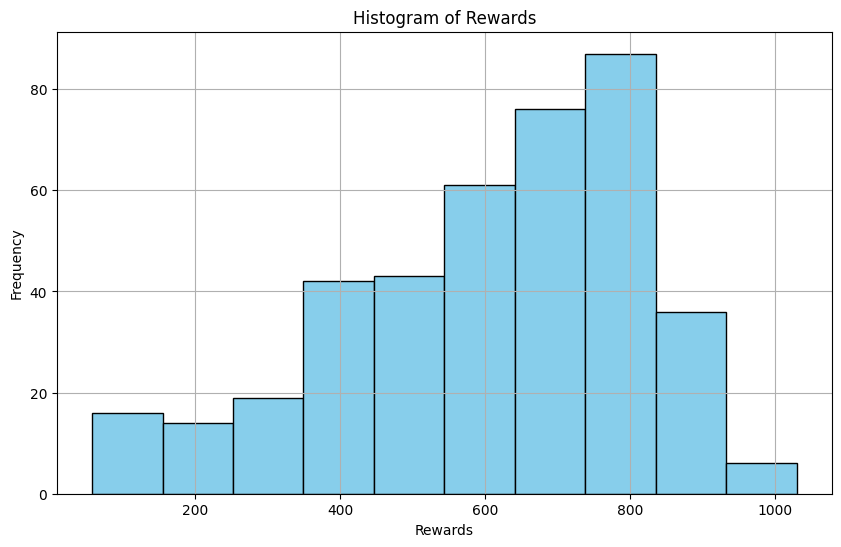

{'n/ep': 50, 'n/st': 86400, 'rews': array([[ 29.65   , 104.585  , 104.74   ,  99.4825 ,  34.415  ,  94.63125,
        119.445  , 109.41125],
       [ 78.54   ,  63.46625,  83.6325 ,  68.29   ,  83.495  ,  88.2525 ,
         93.2575 ,  68.21625],
       [ 65.72   ,  60.24125,  65.315  ,  60.15625,  69.975  ,  89.89875,
         69.8225 ,  79.705  ],
       [ 71.61   ,  71.72375,  47.02   ,  52.0175 ,  61.405  ,  56.7825 ,
         71.425  ,  61.34625],
       [ 50.99   ,  41.425  ,  36.1825 ,  30.9475 ,  45.935  ,  55.78   ,
         30.925  ,  30.8425 ],
       [ 79.91   ,  14.845  ,  74.8175 ,  14.845  ,  84.825  ,   9.61875,
         84.635  ,  89.50375],
       [ 84.06   ,  93.91875,  39.2525 ,  78.61125,  39.115  , 113.495  ,
         49.075  ,  93.41   ],
       [104.27   ,  78.915  ,  99.04   ,  98.89375,  88.935  ,  93.68   ,
        103.5575 , 108.425  ],
       [101.18   ,  96.02875, 100.7525 ,  80.89875,  85.505  ,  95.51375,
         70.425  ,  70.39875],
       [ 84.84   , 

In [4]:
results['rews']
# print(np.mean(results['rews'][results['rews'] > -900]) * 8)


#create a function  to print a histogram of the results['rews']
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_histogram(results):
    # Filter and scale the rewards
    filtered_rews = results['rews'][results['rews'] > -900] * 8
    # filtered_rews = results['lens']

    # Calculate and print the mean of the filtered rewards
    mean_rews = np.mean(filtered_rews)
    print(f"Mean of Filtered Rewards: {mean_rews}")

    # Create the histogram
    plt.figure(figsize=(10, 6))  # Set the size of the plot
    plt.hist(filtered_rews, bins=10, color='skyblue', edgecolor='black')  # Plot the histogram

    # Add labels and title
    plt.xlabel('Rewards')
    plt.ylabel('Frequency')
    plt.title('Histogram of Rewards')

    # Add a grid for easier readability
    plt.grid(True)

    # Show the plot
    plt.show()

    # Print the results dictionary
    print(results)

# plt.hist(results['rews'][results['rews'] > -900] * 8, bins=20)
# plt.show()
plot_histogram(results)